In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [3]:
num_tx=2
num_rx=4
num_samples=256 # number of samples per chirp
num_chirps=204 # number of chirps per frame
num_frames=512

chirp_period = 63.14e-6 # s
slop = 29.982e12 # Hz/s
bw = slop * chirp_period # Hz
c = 3e8 # m/s
range_res = c/(2*bw) # m
print(f'Bandwidth: {bw/1e9:.2f} GHz, range resolution: {range_res:.2f} m')

Bandwidth: 1.89 GHz, range resolution: 0.08 m


In [5]:
import imageio
reader = imageio.get_reader('../rawData/cap2/cap2.mp4', 'ffmpeg')
fps = reader.get_meta_data()["fps"]
duration = reader.get_meta_data()["duration"]
expected_frames = int(fps * duration)
print(f'fps:{fps}, duration:{duration}, expected_frames:{expected_frames}')
frames = []
for i, frame in enumerate(reader):
    if i >= expected_frames*0.8:
        break
    frames.append(frame)

fps:29.92, duration:55.15, expected_frames:1650


1320


IndexError: index 2 is out of bounds for axis 0 with size 2

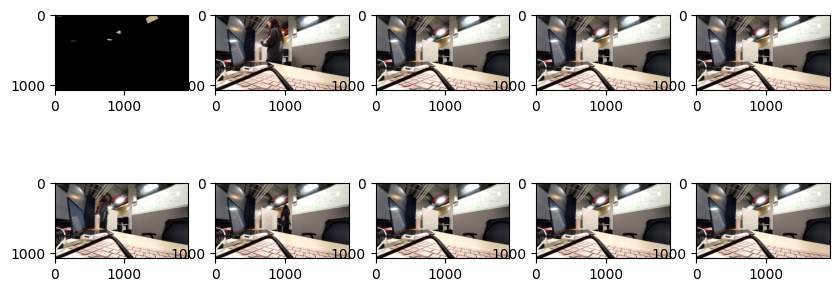

In [6]:
print(len(frames))
period = len(frames)//64
fig, ax = plt.subplots(2, 5, figsize=(10,4))
frame_nums = []
for i in range(63):
    frame_nums.append(i*period)
    ax[i//5, i%5].imshow(frames[i*60])
print(f'frame nums: {frame_nums}')

In [ ]:
from PIL import Image


print(len(frames), len(frames)//63)
period = len(frames)//63
fig, ax = plt.subplots(2, 5, figsize=(10,4))
frame_nums = []
for i in range(63):
    frame_nums.append(i*period)
    im = Image.fromarray(frames[i*period])
    im.save(f'../video/frames/frame_{i*period}.png')

In [19]:
import cv2
import os

image_folder = '../video/frames/'
video_name = '../video/frames/video.mp4'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 4, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

In [10]:
cam_period = 1/fps # s, every "cam_period" time generate one frame
radar_period = num_chirps*(63.14e-6+100e-6) # s, every "radar_period" finish one frame, num_chirps*(chirp_period+chirp_idle_time)
cam_start_time = 0 # s
radar_start_time = 6e-6 # s
print(f'cam_period:{cam_period:.4f}, radar_period:{radar_period:.4f}')
print(cam_period/(63.14e-6+100e-6))

cam_period:0.0334, radar_period:0.0166
204.86980441981197


adc_raw shape:(26738688,)
128 received
tx1:(128, 102, 4, 256), tx2:(128, 102, 4, 256), virtual:(128, 102, 8, 256), num_chirps reduced to half.
cam_frames_timestamp: [0.03342245989304812, 0.06684491978609625, 0.10026737967914437, 0.1336898395721925, 0.16711229946524062, 0.20053475935828874, 0.23395721925133686, 0.267379679144385, 0.30080213903743314, 0.33422459893048123, 0.3676470588235293, 0.4010695187165775, 0.43449197860962563, 0.4679144385026737, 0.5013368983957218, 0.53475935828877, 0.5681818181818181, 0.6016042780748663, 0.6350267379679143, 0.6684491978609625, 0.7018716577540106, 0.7352941176470587, 0.7687165775401068, 0.802139037433155, 0.8355614973262031, 0.8689839572192513, 0.9024064171122993, 0.9358288770053474, 0.9692513368983956, 1.0026737967914436, 1.0360962566844918, 1.06951871657754, 1.102941176470588, 1.1363636363636362, 1.1697860962566844, 1.2032085561497325, 1.2366310160427805, 1.2700534759358286, 1.3034759358288768, 1.336898395721925, 1.370320855614973, 1.403743315508

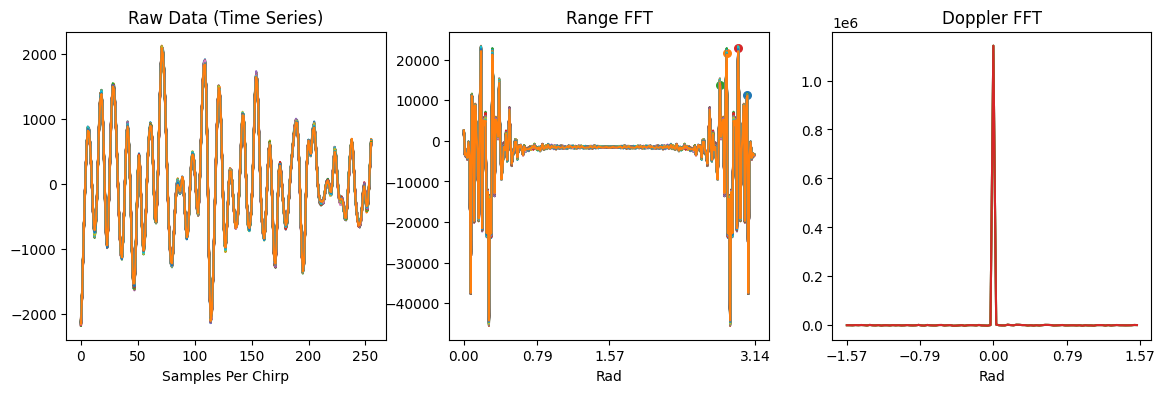

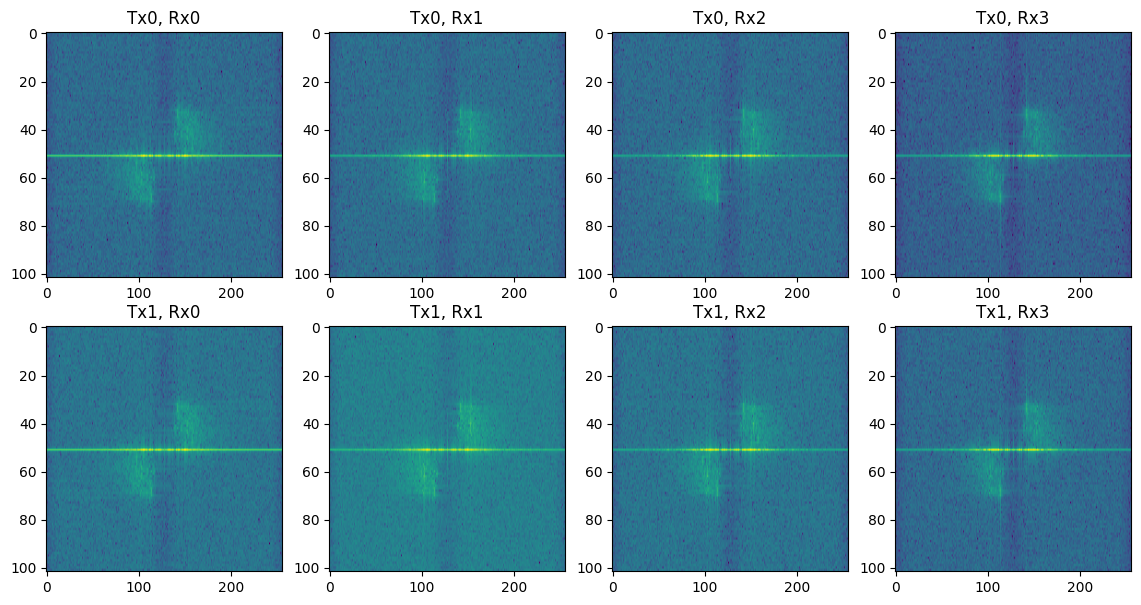

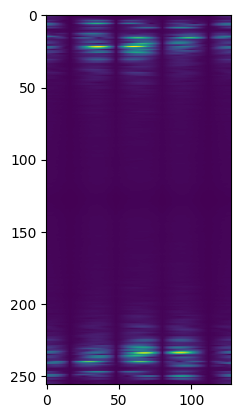

In [14]:
path = '../rawData/cap2/data_Raw_0.bin'
num_tx=2
num_rx=4
num_samples=256
num_chirps=204
num_frames=512

# Correcting complex conversion and reshaping
NUM_RX=num_rx
NUM_SAMPLES=num_samples
NUM_CHIRPS=num_chirps
NUM_FRAMES_=num_frames

RANGE_FFT_SIZE = NUM_SAMPLES
DOPPLER_FFT_SIZE = NUM_CHIRPS
ELEVATION_DIM=num_tx
AZIMUTH_DIM=num_rx
ELEVATION_FFT_SIZE=32
AZIMUTH_FFT_SIZE=128

rad_range = np.arange(start=0, stop=np.pi, step=np.pi/(num_samples))
rad_doppler = np.arange(start=-np.pi/2, stop=np.pi/2, step=np.pi/(num_chirps//2))
rad_azimuth = np.arange(start=-np.pi/2, stop=np.pi/2, step=np.pi/(num_tx*num_rx//2))

adc_raw = np.fromfile(path, dtype=np.int16)
print(f'adc_raw shape:{adc_raw.shape}')

nframes = adc_raw.shape[0] // (num_samples*num_chirps*num_rx)
assert adc_raw.shape[0] == num_samples*num_chirps*num_rx*num_frames or 0 < nframes <num_frames
print(f'{nframes} received')
adc_raw = adc_raw[ :num_samples*num_chirps*num_rx*nframes]

adc_frames = adc_raw.reshape(nframes, num_chirps, num_rx, num_samples)
adc_tx1 = adc_frames[:, ::2, :, :]
adc_tx2 = adc_frames[:, 1::2, :, :]
adc_frames = np.concatenate([adc_tx1, adc_tx2], axis=-2)
num_chirps = num_chirps//2
print(f'tx1:{adc_tx1.shape}, tx2:{adc_tx2.shape}, virtual:{adc_frames.shape}, num_chirps reduced to half.')

frame_idx = [i for i in range(1, nframes)]
cam_frames_timestamp = [i*cam_period for i in frame_idx]
radar_frames_timestamp = [i*radar_period+radar_start_time for i in frame_idx]
print(f'cam_frames_timestamp: {cam_frames_timestamp}')
print(f'radar_frames_timestamp: {radar_frames_timestamp}')

save = False
chirps=[i for i in range(num_chirps)]
for frame in frame_idx[:1]:
    range_fft = np.fft.fft(adc_frames, axis=-1)
    doppler_fft = np.fft.fftshift(np.fft.fft(range_fft, axis=1), axes=1)
    azimuth_fft = np.abs(np.fft.fftshift(np.fft.fft(doppler_fft, axis=2, n=AZIMUTH_FFT_SIZE), axes=2)) #[frames, doppler, channel, range]
    # print(f'range fft:{range_fft.shape}')
    # print(f'doppler fft:{doppler_fft.shape}')
    # print(f'azimuth fft:{azimuth_fft.shape}')

    fig1, ax1 = plt.subplots(1,3, figsize=(14, 4))
    for i, chirp_i in enumerate(chirps):
        ax1[0].plot(adc_frames[frame, chirp_i, 0])
        ax1[1].plot(rad_range, range_fft[frame, chirp_i, 0])
        xticks1 = [0, np.pi/4, np.pi/2, np.pi]
        xticks1 = [np.round(x, 2) for x in xticks1]
        ax1[1].set_xticks(xticks1)
    
    peak_smpls = np.argpartition(range_fft[frame, chirps[0], 0, num_samples//2:], -4)[-4:]+num_samples//2
    # print(f'peak samples:{peak_smpls}')
    for id in peak_smpls:
        ax1[1].scatter(rad_range[id], range_fft[frame, 4, 0, id], s=30)

    for i, peak_smpl in enumerate(peak_smpls):
        ax1[2].plot(rad_doppler, doppler_fft[frame, :, 0, peak_smpls[0]])
        xticks2 = [-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2]
        xticks2 = [np.round(x, 2) for x in xticks2]
        ax1[2].set_xticks(xticks2)
    
    ax1[0].set_title('Raw Data (Time Series)')
    ax1[0].set_xlabel('Samples Per Chirp')

    ax1[1].set_title('Range FFT')
    ax1[1].set_xlabel('Rad')
    ax1[2].set_title('Doppler FFT')
    ax1[2].set_xlabel('Rad')
    
    fig2, ax2 = plt.subplots(2, 4, figsize=(14, 7))
    for i in range(8):
        ax2[i//4, i%4].imshow(20*np.log10(np.abs(np.fft.fftshift(doppler_fft[frame, :, i, :], axes=-1)) + 1e-6), aspect='auto')
        ax2[i//4, i%4].set_title(f'Tx{i//4}, Rx{i%4}')
    
    fig4 = plt.figure()
    # [frames, doppler, channel, range] -> [frames, channel, range]
    # azimuth_fft = np.pad(doppler_fft, pad_width=[(0, 0), (86, 87), (0, 0)], mode='constant')
    range_azimuth = np.mean(azimuth_fft, axis=1)    
    plt.imshow(range_azimuth[frame].transpose())
    # print(f'range resolution:{range_res:.2f}m')

    # Peak detection over doppler/range
    doppler_abs = np.abs(doppler_fft[frame])  # shape: (doppler, virtual_ant, range)
    power_map = np.mean(doppler_abs, axis=1)[:, :NUM_SAMPLES//2]  # sum over virtual antennas
    # print(f'power_map shape:{power_map.shape}')

    npoints = 16
    indices = np.argpartition(power_map.flatten(), -npoints)[-npoints: ]
    peak_idx = np.unravel_index(indices, power_map.shape)
    doppler_bins, range_bins = peak_idx
    # print(f'doppler peak: {peak_idx}')

    azimuth_axis = (1/0.5)*np.linspace(-AZIMUTH_FFT_SIZE/2, AZIMUTH_FFT_SIZE/2, AZIMUTH_FFT_SIZE)/AZIMUTH_FFT_SIZE
    elevation_axis = (1/0.8)*np.linspace(-ELEVATION_FFT_SIZE/2, ELEVATION_FFT_SIZE/2, ELEVATION_FFT_SIZE)/ELEVATION_FFT_SIZE
    # print(f'azimuth range:{azimuth_axis.min():.2f} ~ {azimuth_axis.max():.2f}')
    # print(f'elevation range:{elevation_axis.min():.2f} ~ {elevation_axis.max():.2f}')
    azimuth_axis = np.arcsin(azimuth_axis)
    elevation_axis = np.arcsin(elevation_axis)
    # print(f'azimuth angle range:{(180/np.pi)*azimuth_axis.min():.2f} ~ {(180/np.pi)*azimuth_axis.max():.2f}')
    # print(f'elevation angle range:{(180/np.pi)*elevation_axis.min():.2f} ~ {(180/np.pi)*elevation_axis.max():.2f}')

    fig3, ax3 = plt.subplots(1, 2, figsize=(12, 5))
    for spine in ax3[0].spines.values():
        spine.set_visible(False)
    for spine in ax3[1].spines.values():
        spine.set_visible(False)
    ax3[0].axis('off')
    ax3[1].axis('off')
    ax3[0] = fig3.add_subplot(1, 2, 1, projection='3d')
    ax3[1] = fig3.add_subplot(1, 2, 2, projection='polar')
    # ax = fig.add_subplot(121, projection='polar')
    for doppler_bin, range_bin in zip(doppler_bins, range_bins):
        # AoA estimation
        snapshot = doppler_fft[0, doppler_bin, :, range_bin]  # shape: (8,)
        antenna_2d = snapshot.reshape(ELEVATION_DIM, AZIMUTH_DIM)

        angle_fft2d = np.fft.fftshift(np.fft.fft2(antenna_2d, s=(ELEVATION_FFT_SIZE, AZIMUTH_FFT_SIZE)))
        angle_power = np.abs(angle_fft2d) ** 2
        angle_power /= np.max(angle_power)

        # Estimate azimuth and elevation angles
        elev_bin, azim_bin = np.unravel_index(np.argmax(angle_power), angle_power.shape)

        # azimuth_axis = np.arcsin(np.linspace(-1, 1, AZIMUTH_FFT_SIZE))
        # elevation_axis = np.arcsin(np.linspace(-1, 1, ELEVATION_FFT_SIZE))
        theta = azimuth_axis[azim_bin]
        phi = elevation_axis[elev_bin]

        # Range to Cartesian conversion
        r = range_bin * range_res
        x = r * np.cos(phi) * np.sin(theta)
        y = r * np.cos(phi) * np.cos(theta)
        z = r * np.sin(phi)
        # print(f'azim_bin:{azim_bin}, elev_bin:{elev_bin}, theta:{(180/np.pi)*theta:.2f}, phi:{(180/np.pi)*phi:.2f}, r:{r:.2f}, range_bin:{range_bin}, x: {x}, y: {y}, z: {z}')
        ax3[0].scatter(x, y, z)
        ax3[1].scatter(theta, r, c=z, cmap='viridis')

        # # Add colorbar for Z
        # plt.colorbar(sc, label='Z value')

    ax3[0].set_xlabel('X (m)')
    ax3[0].set_ylabel('Y (m)')
    ax3[0].set_zlabel('Z (m)')
    ax3[0].set_title('3D Cloud Point from Raw Radar Data')

    ax3[1].set_xlabel('Range (m)')
    ax3[1].set_title('Polar Project')

    if save:
        fig1.savefig(f'../processed/test/Raw_FFT_Frame{frame}.jpg')
        fig2.savefig(f'../processed/test/Doppler_Range_Frame{frame}.png')
        fig3.savefig(f'../processed/test/Cloud_Point_Frame{frame}.png')
    plt.close()

In [20]:
import cv2
import os

image_folder = '../processed/test/cloud_point/'
video_name = '../processed/test/cloud_point/video.mp4'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 4, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()